# Projeto Renan - Machine Learning
***

## Importando bibliotecas

In [11]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from scipy.io import arff


# Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             classification_report,
                             RocCurveDisplay,
                             roc_curve,
                             auc, accuracy_score, precision_score)


import warnings
warnings.filterwarnings('ignore')

## Análise do conjunto de dados

In [2]:

d = arff.loadarff("/content/sample_data/indian_pines.arff")
dataset = pd.DataFrame(d[0])



In [3]:
# Coluna com as features
target_col = "Class"
print("Quantas classes existem nesse dataset?\n%d" %(len(dataset[target_col].unique())))
print("\nQuantas instâncias existem no dataset?\n%d" %(dataset.shape[0]))
print("\nQuantas features existem no dataset?\n%d" % (dataset.shape[1]-1))
print("\nQue features são essas?\n%s" % (str([k for k in dataset.keys() if k != target_col])))
print("\nQual o numero de instâncias por classe?")

print(dataset[target_col].value_counts())


Quantas classes existem nesse dataset?
8

Quantas instâncias existem no dataset?
9144

Quantas features existem no dataset?
220

Que features são essas?
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136

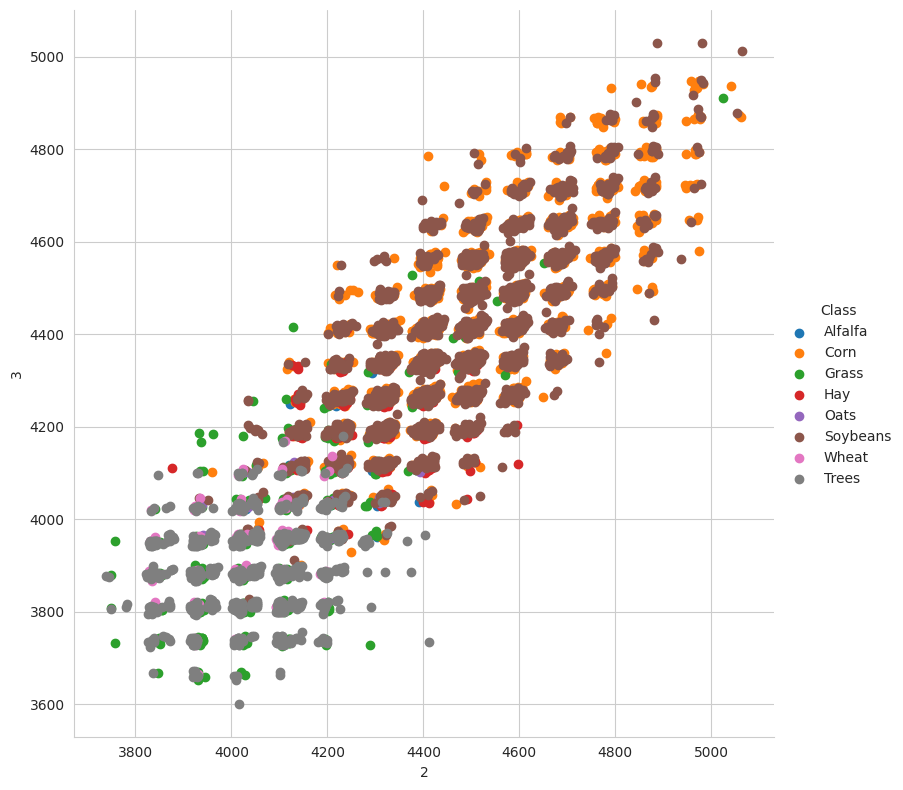

In [4]:
# Distribuição das classes por Features
sns.set_style("whitegrid")
sns.FacetGrid(dataset, hue ="Class",
              height = 8).map(plt.scatter,
                              '2',
                              '3').add_legend()

<Axes: >

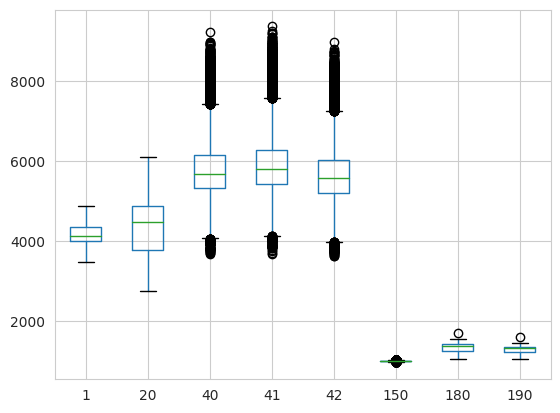

In [5]:
#Boxplot para ajudar a entender disrtibuição das coliunas
dataset.boxplot(column=["1","20","40","41","42","150","180","190"])

##Pré-Processamento e Hiperparamentros

###Setup Inicial

In [6]:
#Refatorando varíaveis de saída
dataset['Class'] = pd.factorize(dataset['Class'])[0]
classArray = ["Alfalfa","Corn","Grass","Hay","Oats","Soybeans","Wheat","Trees"]

#Verificando features
X = dataset.loc[:,"0":"219"]
y = dataset.loc[:,["Class"]]
print(y)
#Gerando objeto kfold
kFoldObj = KFold(n_splits=10,shuffle=True,random_state=199)

      Class
0         0
1         0
2         0
3         0
4         0
...     ...
9139      7
9140      7
9141      7
9142      7
9143      7

[9144 rows x 1 columns]


###Hiperparâmetros e Funções

####Para *KNN*


In [7]:
#Definindo distância Customizada para KNN
def manhattan_custom_distance(x, y, weights=np.array([2, 1])):
    return (abs(x - y)*weights).sum()

#Arrays Hiperparametros
ks = [1,5,8,10,13]
distArray = ["euclidean", "manhattan"]

####Para *Decision Tree*

In [8]:
#Arrays Hiperparametros
maxDepth = [3,5,8,10,15]
criterion = ['gini', 'entropy']


####Para *SVM*

In [9]:
#Arrays Hiperparametros
kerNell = ['linear']
c = [1]


####Para *MLP*

In [19]:
#Arrays Hiperparamentros

n = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_1 = [1,3,5,15,25,35,45,55]
learningRateInit = [0.0001,0.001,0.01,0.1]
learningRate= ['constant','adaptive']

## Treinamento do modelo

###Treinamento **KNN**

####Treinamento *Standard*

In [ ]:
#KNN STD

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# vamos criar um classificador kNN com k=5
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# e ver a sua performance no dataset de teste
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.86      0.79      0.83       747
           2       0.97      0.95      0.96       148
           3       0.98      0.99      0.99       159
           4       1.00      1.00      1.00         5
           5       0.87      0.92      0.90      1176
           6       0.99      1.00      0.99        81
           7       0.99      0.99      0.99       416

    accuracy                           0.90      2744
   macro avg       0.94      0.89      0.91      2744
weighted avg       0.90      0.90      0.90      2744



####Treinamento com *Hyper Tunning*

In [ ]:
#KNN com Hypertunning
model = KNeighborsClassifier()
parameters = {'n_neighbors': ks,
                      'metric':distArray}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 10)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X, y):

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)


Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.89      0.86      0.88       243
           2       0.96      1.00      0.98        52
           3       0.98      1.00      0.99        50
           4       0.00      0.00      0.00         1
           5       0.92      0.94      0.93       416
           6       0.96      1.00      0.98        22
           7       1.00      0.98      0.99       128

    accuracy                           0.93       915
   macro avg       0.84      0.81      0.82       915
weighted avg       0.93      0.93      0.93       915

Fold 0: 0.839
Media do modelo  0.8389385394122522

Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.84      0.79      0.81       266
           2  

###Treinamento **Decision Tree**

####Treinamento *Standard*

In [ ]:
#Decision Tree STD

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

#scikit-learn usa uma versão otimizada do algoritmo CART (similar ao C4.5)
model = DecisionTreeClassifier(max_depth=1)

#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
#print(classification_report(y_test, y_pred))

plt.figure(figsize=(100,100))
tree = plot_tree(model, feature_names=dataset.loc[:,"0":"219"].columns.tolist(),
             class_names= classArray, filled=True)

plt.show()

####Treinamendo com *Hyper Tunning*

In [ ]:
#Decision Tree com Hypertunning
model = DecisionTreeClassifier()
parameters = {'max_depth': maxDepth,
              'criterion':criterion}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 10)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X, y):

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)

###Treinamento **SVM**

####Treinamento *STD*

In [ ]:
#SVM STD

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = SVC()
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.83      0.26      0.40       747
           2       0.53      0.06      0.11       162
           3       0.73      1.00      0.84       141
           4       0.00      0.00      0.00         5
           5       0.68      0.97      0.80      1231
           6       0.94      1.00      0.97        75
           7       0.78      0.99      0.87       370

    accuracy                           0.72      2744
   macro avg       0.56      0.54      0.50      2744
weighted avg       0.73      0.72      0.66      2744



####Treinamento *Hyper Tunning*

In [ ]:
#SVM com Hypertunning
model = SVC()

parameters = {'C':c,
              'kernel': kerNell}
print(parameters)
grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 2)
def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X, y):

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)

{'C': [1], 'kernel': ['linear']}

Melhor parametro: {'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.83      0.84       243
           2       0.96      0.96      0.96        52
           3       1.00      1.00      1.00        50
           4       0.50      1.00      0.67         1
           5       0.90      0.91      0.90       416
           6       1.00      1.00      1.00        22
           7       1.00      0.99      1.00       128

    accuracy                           0.91       915
   macro avg       0.90      0.96      0.92       915
weighted avg       0.91      0.91      0.91       915

Fold 0: 0.902
Media do modelo  0.9016355031961214


###Treinamento **MLP**

####Treinamento *STD*

MLPClassifier(random_state=10)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.47      0.80      0.59       750
           2       0.25      0.88      0.39       155
           3       0.67      0.99      0.80       166
           4       0.00      0.00      0.00         7
           5       0.83      0.40      0.54      1207
           6       0.84      0.93      0.88        71
           7       1.00      0.04      0.08       368

    accuracy                           0.53      2744
   macro avg       0.51      0.50      0.41      2744
weighted avg       0.70      0.53      0.50      2744



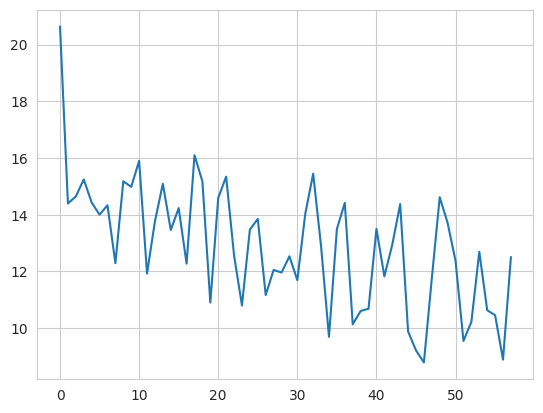

In [17]:
#MLP STD

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = MLPClassifier()

model.fit(X_train, y_train)

print(model)

print(classification_report(y_test, model.predict(X_test)))
plt.plot(model.loss_curve_)

####Treinamento Hyper Tunning

In [20]:
#MLP Hyper

model = MLPClassifier()
train_score = []
val_score = []

parameters = {'hidden_layer_sizes':n,
              'learning_rate': learningRate,
              'learning_rate_init': learningRateInit}

grid = GridSearchCV(estimator = model,
                    param_grid = parameters,
                    scoring = 'precision_macro',
                    cv = 2)

def evaluate_model_with_kfold(kf):
    precision_list = []
    fold = 0
    for train, test in kf.split(X, y):

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        print("\nMelhor parametro:", grid.best_params_)
        print(classification_report(y_test, grid.predict(X_test)))
        print("Fold %d: %.3f" %(fold, precision_score(y_test, y_pred,average="macro")))

        precision_list.append(precision_score(y_test, y_pred,average="macro"))
        print("Media do modelo ", precision_list[fold].mean())

        fold += 1

    precision = np.array(precision_list)
    print("\nPrecisão média (desvio): %.3f +- (%.3f)" %(precision.mean(), precision.std()))

# chamada da função de Treino com KFOLD
evaluate_model_with_kfold(kFoldObj)




Melhor parametro: {'hidden_layer_sizes': 90, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00       243
           2       0.44      0.13      0.21        52
           3       0.98      0.82      0.89        50
           4       0.07      1.00      0.12         1
           5       0.63      0.99      0.77       416
           6       0.95      0.82      0.88        22
           7       0.77      1.00      0.87       128

    accuracy                           0.66       915
   macro avg       0.48      0.60      0.47       915
weighted avg       0.49      0.66      0.55       915

Fold 0: 0.478
Media do modelo  0.4777801762832304

Melhor parametro: {'hidden_layer_sizes': 50, 'learning_rate': 'constant', 'learning_rate_init': 0.0001}
              precision    recall  f1-score   support

           0       0.00      0.00  

##Aplicando modelos para todo dataset

In [23]:
#Aplicando modelo Fold 9, como exeplo, para todo dataset
print(classification_report(y, grid.predict(X)))


              precision    recall  f1-score   support

           0       0.30      0.46      0.36        54
           1       0.64      0.14      0.23      2502
           2       0.64      0.65      0.65       523
           3       0.89      0.86      0.87       489
           4       0.17      0.05      0.08        20
           5       0.64      0.95      0.76      4050
           6       0.94      0.80      0.87       212
           7       0.95      0.95      0.95      1294

    accuracy                           0.70      9144
   macro avg       0.64      0.61      0.60      9144
weighted avg       0.70      0.70      0.64      9144

